# Introduction to Decision Trees

||continuous|categorical|
|---|---|---|
|**supervised**|**regression**|**classification**|
|**unsupervised**|dimension reduction|clustering|

**Decision tree** classifiers are attractive models if we care about interpretability. Like the name decision tree suggests, we can think of this model as breaking down our data by making decisions based on asking a series of questions.

In [65]:
# Standard imports for data analysis packages in Python
from __future__ import division, print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This enables inline Plots
%matplotlib inline

### Titanic Dataset

* Problem: Predict whether a passenger survived, given other attributes

In [66]:
# read in the data
titanic = pd.read_csv('https://sampathweb.github.io/datasets/titanic/titanic.csv')
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.28,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.92,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.10,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.86,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.07,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.13,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.07,NaN,C


In [67]:
# How many Survived?
print(titanic['survived'].value_counts())

print("Probability of Survival:", titanic['survived'].mean())

0    549
1    342
Name: survived, dtype: int64
Probability of Survival: 0.383838383838


So, Not knowing anything else, if I were to build a model, I would say no one survived and I would be right 62% of the time.

In [68]:
# Can I do better - If I know the Class they travelled in?

titanic.groupby('pclass')[['survived']].mean()

,survived
pclass,
1,0.63
2,0.47
3,0.24


Looks like I will predict them to be Survivied if they travelled in 1st class and not survived when they travelled on 2nd or 3rd class tickets.

In [69]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.74
male,0.19


In [70]:
titanic.groupby(['sex', 'pclass'])[['survived']].agg(['mean', 'count'])

survived      
                  mean count
sex    pclass               
female 1          0.97    94
       2          0.92    76
       3          0.50   144
male   1          0.37   122
       2          0.16   108
       3          0.14   347

The Gini index is defined by K

$$Gini(t)=1-\sum\limits_{i=0}^{c} [p(i|t)]^2$$

G = 􏰀 pˆmk (1 − pˆmk ), k=1
a measure of total variance across the K classes. The Gini index takes on a small value if all of the pˆmk’s are close to zero or one.
• For this reason the Gini index is referred to as a measure of node purity — a small value indicates that a node contains predominantly observations from a single class.

In [87]:
# Gini Coefficient for Gender

gini_sex = 1 - (0.74 ** 2 + 0.19 ** 2)
gini_sex

0.4163

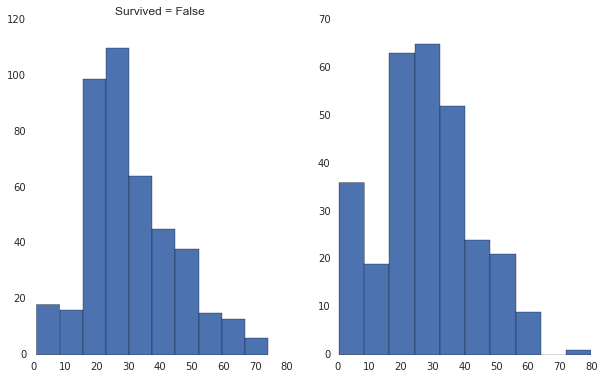

In [99]:
_, ax = plt.subplots(1, 2, figsize=(10,6))
titanic[titanic["survived"] == 0].age.hist(ax=ax[0])
ax[0].set_title("Survived = False")
titanic[titanic["survived"] == 1].age.hist(ax=ax[1])

In [12]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [13]:
# look for missing values
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

### Prediction Problem

Predict who survived - This is our response, and is already encoded as 0=died and 1=survived.


### Identify Features we want in our Model

* Pclass - These are the passenger class categories (1=first class, 2=second class, 3=third class). They are ordered, so we'll leave them as-is.
* Sex -  This is a binary category, so we should encode as 0=female and 1=male.
* Age - We need to fill in the missing values.
* Sibling Count
* embarked - This is the port they emarked from. There are three unordered categories, so we'll create dummy variables.
Let's choose our response and a few features, and decide whether we need to adjust them:

- **pclass:** These are the passenger class categories (1=first class, 2=second class, 3=third class). They are ordered, so we'll leave them as-is.
- **sex:** This is a binary category, so we should encode as 0=female and 1=male.
- **age:** We need to fill in the missing values.
- **embarked:** This is the port they emarked from. There are three unordered categories, so we'll create dummy variables.

#### Imputing Values - AGE

In [14]:
# encode sex feature
titanic['sex'] = titanic.sex.map({'female':0, 'male':1})

In [15]:
# fill in missing values for age
titanic.age.fillna(titanic.age.mean(), inplace=True)

# Challenge: Populate the missing Age from a Normal Distribution centered on Average Age and Standard Deviation

### Feature Selection

In [16]:
y_data = titanic['survived']

X_data = titanic[['pclass', 'sex', 'age', 'sibsp', 'embarked']]
X_data.info()

In [20]:
X_data = pd.get_dummies(X_data)
X_data

,pclass,sex,age,sibsp,embarked_C,embarked_Q,embarked_S
0,3,1,22.0,1,0,0,1
1,1,0,38.0,1,1,0,0
2,3,0,26.0,0,0,0,1
3,1,0,35.0,1,0,0,1
4,3,1,35.0,0,0,0,1
5,3,1,29.7,0,0,1,0
6,1,1,54.0,0,0,0,1
7,3,1,2.0,3,0,0,1
8,3,0,27.0,0,0,0,1
9,2,0,14.0,1,1,0,0


### Create Train / Test Split

In [21]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=12, test_size=0.2)

## Implementing Decision Trees With Scikit-learn

Now, we can create a new DecisionTreeClassifier and use the fit method of the classifier to do the learning job.

In [73]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3,min_samples_leaf=5)
# clf.set_params(min_samples_leaf=4)
# clf.set_params(max_depth=3)
clf = clf.fit(X_train,y_train)

The decision tree we have built represents a series of decisions based on the training data. To classify an instance, we should answer the question at each node. For example, at our root node, the question is: Is sex<=0.5? (are we talking about a woman?). If the answer is yes, you go to the left child node in the tree; otherwise you go to the right child node. You keep answering questions (was she in the third class?, was she in the first class?, and was she below 13 years old?), until you reach a leaf. When you are there, the prediction corresponds to the target class that has most instances (that is if the answers are given to the previous questions). In our case, if she was a woman from second class, the answer would be 1 (that is she survived), and so on. Let's drawit, using pyplot:

In [74]:
X_data.columns.tolist()

['pclass', 'sex', 'age', 'sibsp', 'embarked_C', 'embarked_Q', 'embarked_S']

### Visualize Tree Model

In [75]:
from sklearn.externals.six import StringIO
with open("titanic_decision_tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [76]:
!cat titanic_decision_tree.dot

digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 0.5\ngini = 0.4659\nsamples = 712\nvalue = [449, 263]"] ;
1 [label="X[0] <= 2.5\ngini = 0.3811\nsamples = 242\nvalue = [62, 180]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[6] <= 0.5\ngini = 0.1078\nsamples = 140\nvalue = [8, 132]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 44\nvalue = [0, 44]"] ;
2 -> 3 ;
4 [label="gini = 0.1528\nsamples = 96\nvalue = [8, 88]"] ;
2 -> 4 ;
5 [label="X[6] <= 0.5\ngini = 0.4983\nsamples = 102\nvalue = [54, 48]"] ;
1 -> 5 ;
6 [label="gini = 0.414\nsamples = 41\nvalue = [12, 29]"] ;
5 -> 6 ;
7 [label="gini = 0.4289\nsamples = 61\nvalue = [42, 19]"] ;
5 -> 7 ;
8 [label="X[2] <= 13.0\ngini = 0.2908\nsamples = 470\nvalue = [387, 83]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="X[3] <= 2.5\ngini = 0.4898\nsamples = 28\nvalue = [12, 16]"] ;
8 -> 9 ;
10 [label="gini = 0.1172\nsamples = 16\nvalue = [1, 15]"] ;
9 -> 10 ;
11 [label="gini = 0.1528\

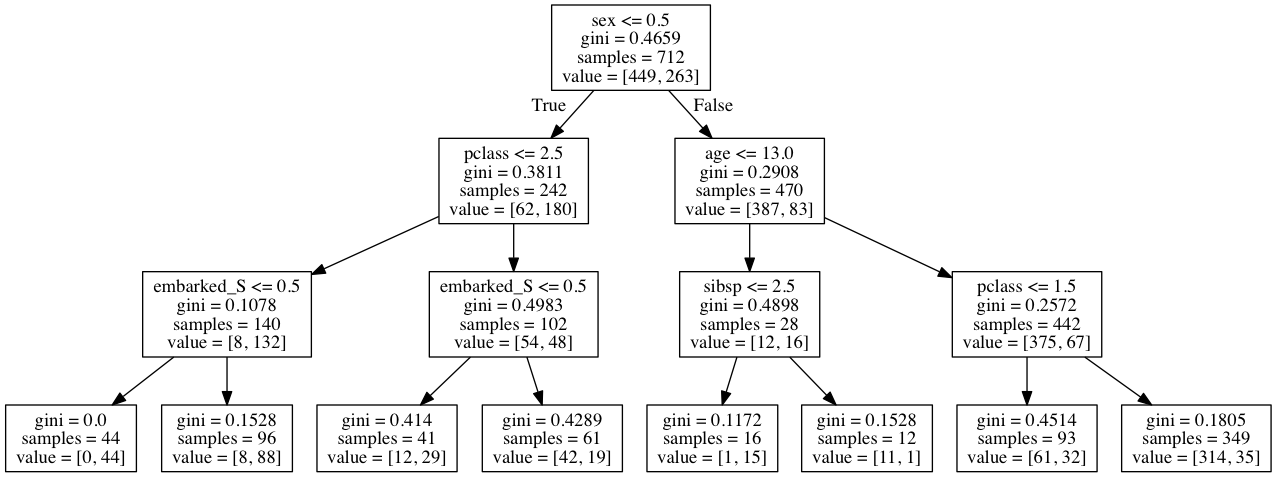

In [77]:
import pydot
from IPython.core.display import Image 

dot_data = StringIO()
feature_names = X_data.columns.tolist()
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('titanic_decision_tree.png') 
Image(filename='titanic_decision_tree.png')

In [80]:
# Overall Accuracy of the model
clf.score(X_test, y_test)

0.77094972067039103

In [28]:
from sklearn import metrics

y_pred = clf.predict(X_test)
# Confusion Matrix for Type 1 and Type 2 Error
metrics.confusion_matrix(y_test, y_pred)

# Examine Precision and Recall
# print classification_report(y_test, y_pred)

array([[88, 12],
       [35, 44]])

In [29]:
def confusion_matrix_df(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix_df(y_test, y_pred)

error rate: 0.26


Predicted label,0,1
True label,,
0,88,12
1,35,44


In [30]:
def plot_confusion_matrix(y_pred, y):
    plt.matshow(metrics.confusion_matrix(y, y_pred),
               cmap=plt.cm.binary)
    plt.colorbar()
    plt.xlabel('true value')
    plt.ylabel('predicted value')

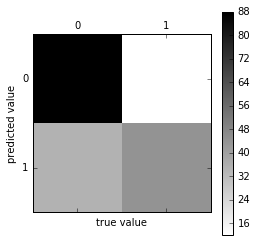

In [31]:
plot_confusion_matrix(y_pred, y_test)

## Prevent Overfitting

In addition to determining splits, we also need a stopping criterion to tell us when we’re done.

For example, we can stop when all records belong to the same class, or when all records have the same attributes.
This is correct in principle, but would likely lead to overfitting.

Alternatively we could build the full tree, and then perform pruning as a post-processing step.
To prune a tree, we examine the nodes from the bottom-up and simplify pieces of the tree (according to some criteria).

## Review

* A decision tree is complete when all results can belong to a single partition
* To prevent overfitting, we prune trees after compleition
* Pruning is a form of generalization that simplifies a decision tree

#### When to use them:

* Lots of Data and Features
* outliers
* Data is Dirty or Missing - Pour data without cleaning

### When not to use them:

* Not good for small datasets - high noise to signal
* When there exists a linear relationship between Features and the Predicted outcome

** It's an important tool in the Supervised Learning and is the foundation for much more complex

### In practice, decision trees are seldem used alone

### Instead we use ensembles to improve our model

### Exercise: Submit to Kaggle

* Get the NEW Data from Kaggle that we need to Predict
* Impute the same way we did the Training Data
* Make Prediction using the same Classifer Object
* Build a CSV and upload to Kaggle
* Check the Leaderboard and Tweet yay!